# Deep Word Meaning
Do the meanings of words used in the political discourse change over time, can we quantify this? But this time we will be using a BERT GoEmotions model.

In [1]:
import pandas as pd
import os
import sys
import json
import re

# from transformers import BertTokenizer
# from model import BertForMultiLabelClassification
# from multilabel_pipeline import MultiLabelPipeline
from fuzzysearch import find_near_matches
import re
from tqdm import tqdm
import numpy as np 
import pandas as pd
import pickle
import swifter

In [2]:
import os
import sys
import pickle
from tqdm import tqdm
import itertools
import dateparser
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import matplotlib.dates as mdates

git_dir = os.path.abspath('../')

# Define data path
data_path = os.path.join(git_dir, 'data', 'pm-transcripts')\

# Define data output path
data_output_path = os.path.join(git_dir, 'data', 'hansard-parsed')

# Pickle path
df_pickle_path = os.path.join(data_output_path, 'hansard-senate-emotions-ekman.pkl')

# shared-scratch/language-of-leadership/data/hansard-parsed/hansard-senate-emotions-ekman.pkl
#Read in, make string lists into strings
df = pd.read_pickle(df_pickle_path)

In [3]:
# Drop useless columns and set a datetime index.
def clean_df(df):
    df['date'] = pd.to_datetime(df['date'])
    df = df[df['date']>datetime.datetime(year=2011, month=6, day=1)]
    df = df.sort_values('date').set_index('date')
    return df 

df = clean_df(df)

In [4]:
def vectorise_emotion(emotion, em_map):
    arr = np.zeros(len(em_map))
    for idx, em in enumerate(emotion['labels']):
        arr[em_map[em]] = emotion['scores'][idx]
    return arr

def fuzzy_colocation(sequences, search_key):
    ret = []
    for index, sequence in enumerate(sequences):
        if any([len(find_near_matches(subsequence, sequence, max_l_dist=2)) > 0 
             for subsequence in search_key]):
            ret.append(index)
        # Return neighbour indicies?
    return ret

def generate_keyword_in_context_sentiment(
    df_pass, # Copied after pass, new df is returned.
    keyword_tag, # Id for the dataframe
    keywords, # List of words, see how sentiment for this class changes over time.
    verbose = True
):
    if verbose: print("Copying df")
    df = df_pass.copy()

    if verbose: print("Starting fuzzy matching")
    df[f'{keyword_tag}_idx'] = df['sentences'].swifter\
    .apply(lambda x: fuzzy_colocation(x, keywords))
    
    # For each document we now have a list of sentences that express some emotion
    # Average over them.
    def calculate_mean_em(row):
        emotions_size = len(row['emotions_vecs'])
        return np.mean([row['emotions_vecs'][idx] 
                   for idx in row[f'{keyword_tag}_idx'] 
                   if idx < emotions_size], axis=0).tolist()
    
    if verbose: print("Calculating mean emotion per document per keyword")
    df[f'{keyword_tag}'] = df.swifter.apply(calculate_mean_em, axis = 1)
    return df

def plot_keyword_dep(
    df,
    keyword_tag,
    emotion_map
):
    view = df[f'{keyword_tag}'].apply(pd.Series)
    view = view.rename(columns = lambda col: emotion_map[col])

    plt.figure()
    view.plot()
    plt.figure()
    view_rolling = view.rolling('28d').mean()
    view_rolling.plot()

In [5]:
ekman_list = ['anger', 
              'disgust', 
              'fear', 
              'joy', 
              'sadness', 
              'surprise', 
              'neutral']
ekman_map = dict(zip(ekman_list, range(len(ekman_list))))

positive_emotions = ['admiration', 
                     'amusement',
                     'approval',
                     'caring',
                     'desire',
                     'excitement',
                     'gratitude',
                     'joy',
                     'love',
                     'optimism',
                     'pride',
                     'relief']
negative_emotions = ['anger',
                     'annoyance',
                     'disappointment',
                     'disapproval',
                     'disgust',
                     'embarrassment',
                     'fear',
                     'grief',
                     'nervousness',
                     'remorse',
                     'sadness']
ambiguous_emotions = ['confusion',
                      'curiosity',
                      'realization',
                      'surprise']
neutral_emotions = ['neutral']

emotions_list = positive_emotions + negative_emotions + ambiguous_emotions + neutral_emotions
emotions_map = dict(zip(emotions_list, range(len(emotions_list))))

In [6]:
# Pad emotion into a vector 
df[f'emotions_vecs'] = df['sentences_emotions'].swifter\
    .apply(lambda emotions: [vectorise_emotion(emotion, ekman_map) 
                             for emotion in emotions])

/home/jupyter-prithvi/.local/lib/python3.8/site-packages/swifter/swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


In [7]:
woi = {
    'ind': ['aboriginal', 'first nations', 'aborigine', 'indigenous', 'torres strait island'],
    'econ': ['economy', 'economic'],
    'aus': ['australia', 'australian', 'aussie', 'australians'],
    'gov': ['government'],
    'ref': ['immigrant', 'asylum seeker', 'boat people', 'illegal arrivals', 'boat arrivals'],
    'env': ['fire', 'bushfire', 'climate change', 'climate action', 'extinction', 'global warming', 'greenhouse', 'emissions', 'environment', 'coral reef', 'reef', 'climate', 'degradation', 'sustainability']
}

In [ ]:
df_ = df.copy()
key = 'aus'
df_ = generate_keyword_in_context_sentiment(df_, key, woi[key])

Copying df
Starting fuzzy matching


In [ ]:
df_ = df.copy()
for key in woi:
    df_ = generate_keyword_in_context_sentiment(df_, key, woi[key])

In [ ]:
plot_keyword_dep(df_, 'ref', list(ekman_map.keys()))

In [ ]:
plot_keyword_dep(df_, 'aus', list(ekman_map.keys()))

<Figure size 432x288 with 0 Axes>

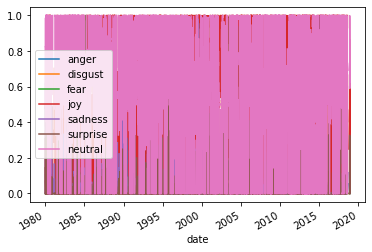

<Figure size 432x288 with 0 Axes>

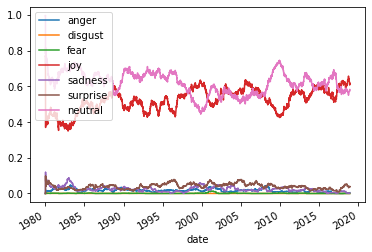

In [13]:
plot_keyword_dep(df_, 'econ', list(ekman_map.keys()))

<Figure size 432x288 with 0 Axes>

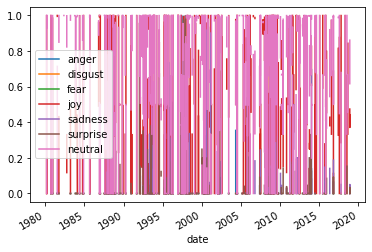

<Figure size 432x288 with 0 Axes>

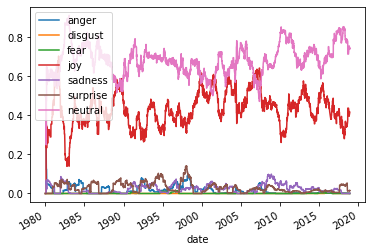

In [14]:
plot_keyword_dep(df_, 'ind', list(ekman_map.keys()))

<Figure size 432x288 with 0 Axes>

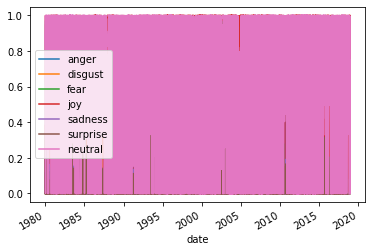

<Figure size 432x288 with 0 Axes>

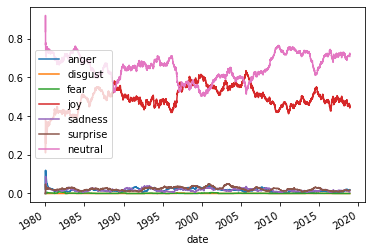

In [15]:
plot_keyword_dep(df_, 'gov', list(ekman_map.keys()))

<Figure size 432x288 with 0 Axes>

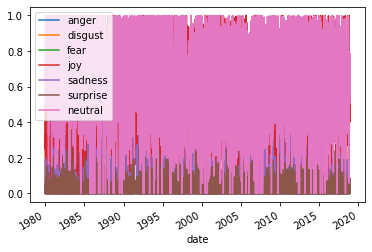

<Figure size 432x288 with 0 Axes>

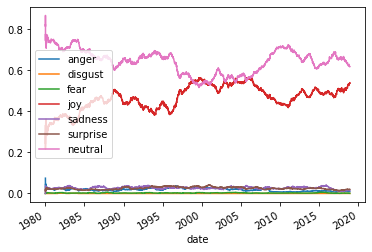

In [16]:
plot_keyword_dep(df_, 'env', list(ekman_map.keys()))